In [ ]:
# --- DATA PREPROCESSING ---

import pandas as pd
import numpy as np
import re

# Load the dataset
df = pd.read_csv("mental-heath-in-tech-2016.csv")
print(f"Initial dataset shape: {df.shape}")

# Rename columns to snake_case
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(r'[^a-zA-Z0-9]+', '_', regex=True)
    .str.replace(r'_+', '_', regex=True)
    .str.strip('_')
)
print("Column names standardized.")

# Convert all string data (in the rows) to lowercase
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.lower()

print("Converted all rows to lowercase.")

# Drop unnecessary columns
cols_to_drop = [
    'timestamp', 'comments', 'state', 'country', 'tech_company',
    'why_or_why_not', 'why_or_why_not_1',
    'what_is_your_gender',
    'what_country_do_you_live_in', 'what_us_state_or_territory_do_you_live_in',
    'what_country_do_you_work_in', 'what_us_state_or_territory_do_you_work_in',
    'what_is_your_age'
]
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
print(f"Dropped columns: {', '.join([col for col in cols_to_drop if col in df.columns])}")

# Handle missing values in object columns
object_cols = df.select_dtypes(include='object').columns
for col in object_cols:
    mode = df[col].mode(dropna=True)
    df[col] = df[col].fillna(mode[0] if not mode.empty else 'not_disclosed')

# Remove date-like or malformed entries across object columns
date_pattern = r'^(19|20)\d{2}$|^\d{1,2}[/-]\d{1,2}[/-]\d{2,4}$'
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].apply(
        lambda x: 'not_disclosed' if isinstance(x, str) and re.match(date_pattern, x.strip()) else x
    )

# Clean 'how_many_employees_does_your_company_or_organization_have'
emp_col = 'how_many_employees_does_your_company_or_organization_have'
if emp_col in df.columns:
    date_pattern = r'^(19|20)?\d{2}[/-]\d{1,2}[/-]\d{1,2}$|^\d{1,2}[/-]\d{1,2}[/-](19|20)?\d{2}$'
    df[emp_col] = df[emp_col].astype(str).apply(
        lambda x: None if re.match(date_pattern, x.strip()) else x
    )
    mode_val = df[emp_col].mode(dropna=True)
    df[emp_col] = df[emp_col].fillna(mode_val[0] if not mode_val.empty else 'not_disclosed')

# Fill missing numeric columns with median
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

print("Missing values handled (mode for categorical, median for numeric).")

# Normalize common text responses
yes_no_map = {
    'yes': 'yes', 'no': 'no', 'nope': 'no', 'y': 'yes', 'n': 'no',
    "don't know": 'unknown', "i don't know": 'unknown',
    'not applicable to me': 'N/A', 'not sure': 'unknown', 'unsure': 'unknown'
}
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].apply(
        lambda x: yes_no_map.get(str(x).lower(), x) if isinstance(x, str) else x
    )

print("Responses normalized (yes/no/unknown).")

# Expand multi-response work position column
position_col = 'which_of_the_following_best_describes_your_work_position'
if position_col in df.columns:
    position_dummies = df[position_col].str.get_dummies(sep='|')
    df = pd.concat([df, position_dummies], axis=1)
    print(f"Expanded '{position_col}' into {position_dummies.shape[1]} dummy columns.")

# Preview sample
print("\nSample preview of cleaned data:")
print(df.sample(3).reset_index(drop=True))

# Save cleaned CSV
df.to_csv("Cleaned_Mental_Health_Data.csv", index=False)
print(f"Final dataset shape: {df.shape}")
print("Cleaned dataset saved as 'Cleaned_Mental_Health_Data.csv'.")

Initial dataset shape: (1433, 63)
Column names standardized.
Converted all rows to lowercase.
Dropped columns: 
Missing values handled (mode for categorical, median for numeric).
Responses normalized (yes/no/unknown).
Expanded 'which_of_the_following_best_describes_your_work_position' into 12 dummy columns.

Sample preview of cleaned data:
   are_you_self_employed  \
0                      0   
1                      1   
2                      0   

  how_many_employees_does_your_company_or_organization_have  \
0                                            100-500          
1                                             26-100          
2                                            100-500          

   is_your_employer_primarily_a_tech_company_organization  \
0                                                1.0        
1                                                1.0        
2                                                1.0        

   is_your_primary_role_within_your_company_rel

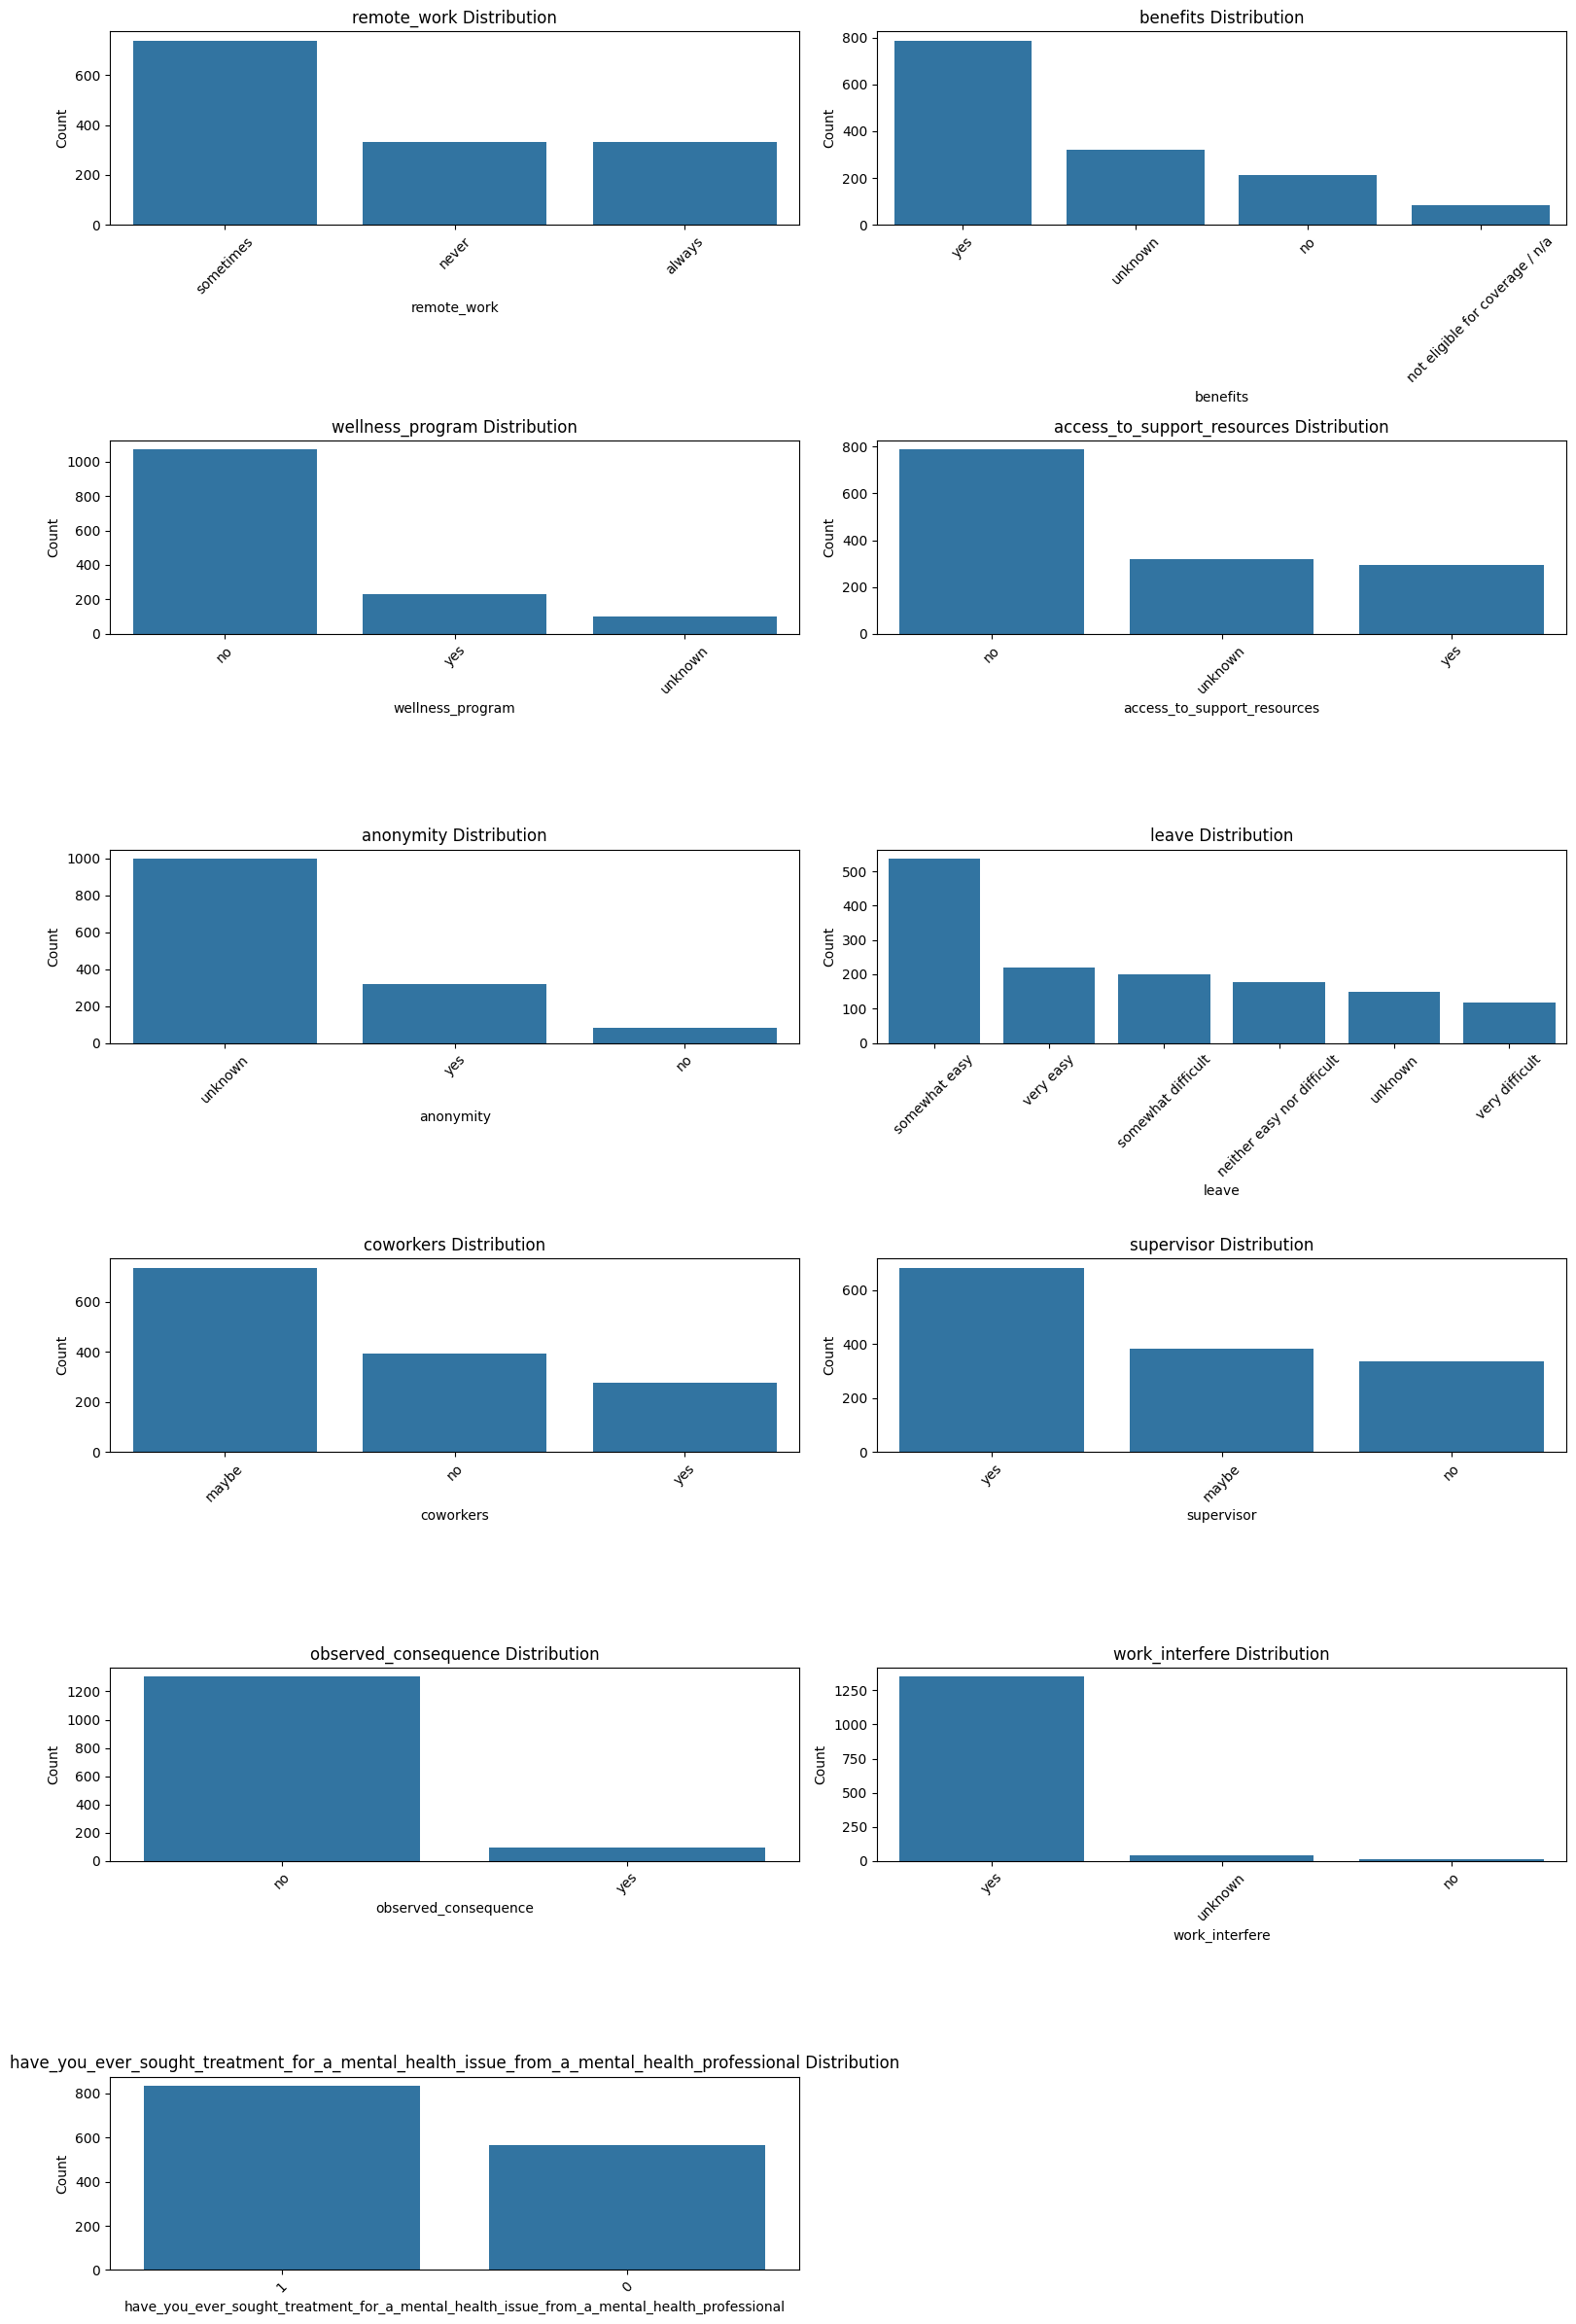

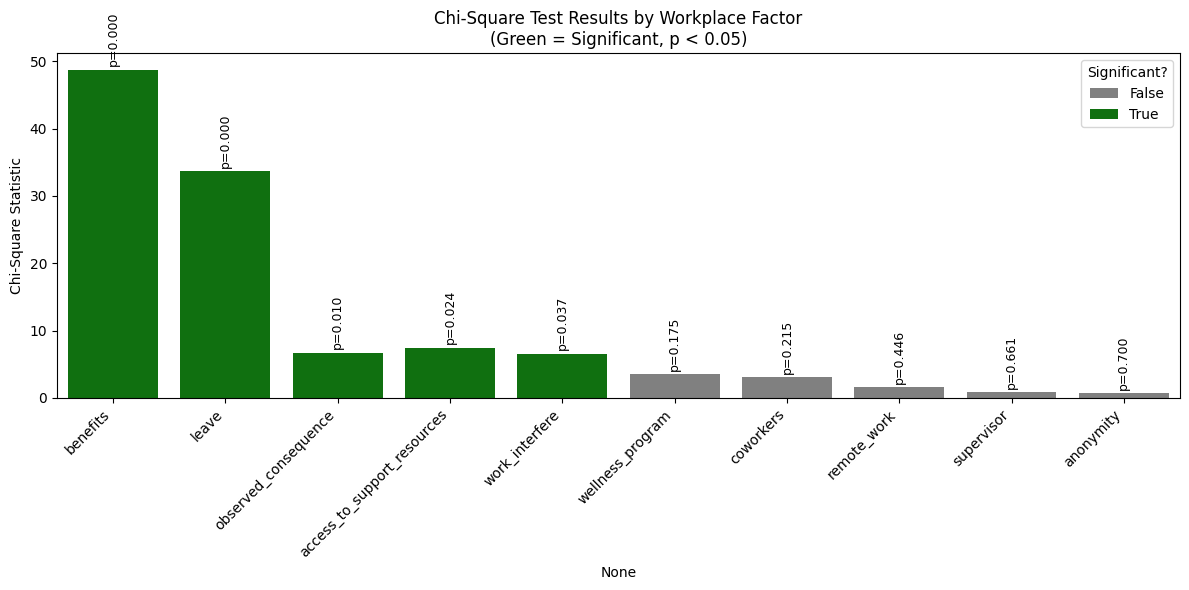

In [ ]:
# --- RQ1: Which workplace factors are significantly associated with mental health challenges reported by tech employees? ---

# === 1. Import Libraries ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

# === 2. Load Dataset ===
df = pd.read_csv("Final_Cleaned_Mental_Health_Data.csv")

# === 3. Setup Variables ===
treatment_col = 'have_you_ever_sought_treatment_for_a_mental_health_issue_from_a_mental_health_professional'

workplace_factors_map = {
    'do_you_work_remotely': 'remote_work',
    'does_your_employer_provide_mental_health_benefits_as_part_of_healthcare_coverage': 'benefits',
    'has_your_employer_ever_formally_discussed_mental_health_for_example_as_part_of_a_wellness_campaign_or_other_official_communication': 'wellness_program',
    'does_your_employer_offer_resources_to_learn_more_about_mental_health_concerns_and_options_for_seeking_help': 'access_to_support_resources',
    'is_your_anonymity_protected_if_you_choose_to_take_advantage_of_mental_health_or_substance_abuse_treatment_resources_provided_by_your_employer': 'anonymity',
    'if_a_mental_health_issue_prompted_you_to_request_a_medical_leave_from_work_asking_for_that_leave_would_be': 'leave',
    'would_you_feel_comfortable_discussing_a_mental_health_disorder_with_your_coworkers': 'coworkers',
    'would_you_feel_comfortable_discussing_a_mental_health_disorder_with_your_direct_supervisor_s': 'supervisor',
    'have_you_heard_of_or_observed_negative_consequences_for_co_workers_who_have_been_open_about_mental_health_issues_in_your_workplace': 'observed_consequence',
    'do_you_believe_your_productivity_is_ever_affected_by_a_mental_health_issue': 'work_interfere'
}

relevant_columns = list(workplace_factors_map.keys()) + [treatment_col]
df_subset = df[relevant_columns].dropna()  # Drop missing values
df_subset = df_subset.rename(columns=workplace_factors_map)

# === 4. Encode Columns ===
encoded_df = df_subset.copy()
le = LabelEncoder()
for col in encoded_df.columns:
    encoded_df[col] = le.fit_transform(encoded_df[col].astype(str))

# === 5. Chi-Square Analysis ===
chi_square_results = {}
for factor in workplace_factors_map.values():
    contingency = pd.crosstab(encoded_df[factor], encoded_df[treatment_col])
    chi2, p, dof, _ = chi2_contingency(contingency)
    chi_square_results[factor] = {'chi2': chi2, 'p_value': p, 'dof': dof}

# === 6. Descriptive Statistics ===
descriptive_stats = df_subset.describe(include='all')
frequencies = {col: df_subset[col].value_counts(normalize=True) * 100 for col in df_subset.columns}

# === 7. Distribution Plots (2 per row) ===
fig, axes = plt.subplots(6, 2, figsize=(16, 24))  # 6 rows × 2 columns
axes = axes.flatten()

for i, col in enumerate(df_subset.columns):
    sns.countplot(data=df_subset, x=col, order=df_subset[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# === 8. Chi-Square Results Table ===
chi_square_df = pd.DataFrame(chi_square_results).T
chi_square_df = chi_square_df.sort_values('p_value')  # Optional sorting

# Add significance flag
chi_square_df['significant'] = chi_square_df['p_value'] < 0.05

# Plot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    x=chi_square_df.index,
    y=chi_square_df['chi2'],
    hue=chi_square_df['significant'],
    palette={True: "green", False: "gray"}
)

# Annotate with p-values
for i, (chi2, p) in enumerate(zip(chi_square_df['chi2'], chi_square_df['p_value'])):
    barplot.text(i, chi2 + 0.5, f"p={p:.3f}", ha='center', va='bottom', fontsize=9, rotation=90)

plt.xticks(rotation=45, ha='right')
plt.ylabel('Chi-Square Statistic')
plt.title('Chi-Square Test Results by Workplace Factor\n(Green = Significant, p < 0.05)')
plt.legend(title='Significant?')
plt.tight_layout()
plt.show()


--- MODEL PERFORMANCE ---

Logistic Regression
Accuracy : 0.6039
Precision: 0.6238
Recall   : 0.8118
F1-Score : 0.7055
ROC AUC  : 0.6176

Random Forest
Accuracy : 0.6018
Precision: 0.6228
Recall   : 0.8084
F1-Score : 0.7036
ROC AUC  : 0.5871

SVM
Accuracy : 0.6202
Precision: 0.6280
Recall   : 0.8589
F1-Score : 0.7255
ROC AUC  : 0.5645


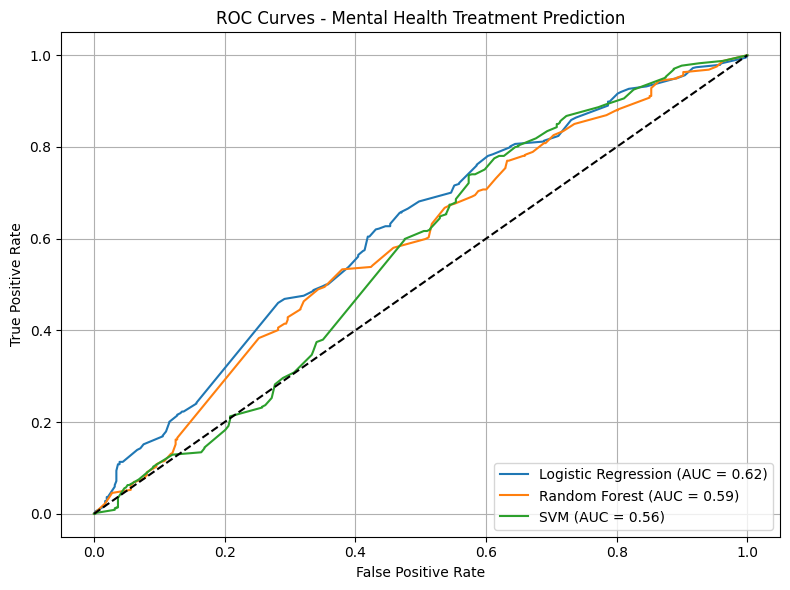

In [ ]:
# --- RQ2: Performance Metrics of Machine Learning Models ---

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)

# --- STEP 2: LOAD DATA ---
df = pd.read_csv("Final_Cleaned_Mental_Health_Data.csv")

# --- STEP 3: FEATURES & TARGET ---
features = [
    'does_your_employer_provide_mental_health_benefits_as_part_of_healthcare_coverage',
    'if_a_mental_health_issue_prompted_you_to_request_a_medical_leave_from_work_asking_for_that_leave_would_be',
    'have_you_heard_of_or_observed_negative_consequences_for_co_workers_who_have_been_open_about_mental_health_issues_in_your_workplace',
    'does_your_employer_offer_resources_to_learn_more_about_mental_health_concerns_and_options_for_seeking_help',
    'do_you_believe_your_productivity_is_ever_affected_by_a_mental_health_issue'
]
target = 'have_you_ever_sought_treatment_for_a_mental_health_issue_from_a_mental_health_professional'

# --- STEP 4: CLEAN & ENCODE ---
df = df[features + [target]].dropna()
X = pd.get_dummies(df[features], drop_first=True)
y = df[target].astype(int)

# --- STEP 5: TRAIN/TEST SPLIT (30% train, 70% test) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# --- STEP 6: SCALE FEATURES ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- STEP 7: DEFINE MODELS ---
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True)
}

# --- STEP 8: TRAIN, EVALUATE, PLOT ROC ---
print("\n--- MODEL PERFORMANCE ---")
plt.figure(figsize=(8, 6))

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Probabilities for ROC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_prob = model.decision_function(X_test_scaled)

    # Evaluation Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Print Results
    print(f"\n{name}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"ROC AUC  : {roc_auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# --- Final ROC Plot Settings ---
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Mental Health Treatment Prediction")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# --- RQ3: Which specific mental health disorders can be predicted using workplace-related factors, and what are the most influential predictors for each? ---


import pandas as pd
from collections import Counter

# Load your CSV file
df = pd.read_csv("Final_Cleaned_Mental_Health_Data.csv")

# Combine the two relevant columns
col1 = df['if_yes_what_condition_s_have_you_been_diagnosed_with'].dropna()
col2 = df['if_so_what_condition_s_were_you_diagnosed_with'].dropna()
combined = pd.concat([col1, col2]).dropna().astype(str).str.lower()

# Split entries by semicolon and flatten the list
all_disorders = combined.str.split(';').explode().str.strip()

# Count and print the top disorders mentioned
disorder_counts = Counter(all_disorders)
for disorder, count in disorder_counts.most_common(15):
    print(f"{disorder}: {count}")


anxiety disorder (generalized, social, phobia, etc)|mood disorder (depression, bipolar disorder, etc): 1132
mood disorder (depression, bipolar disorder, etc): 1011
anxiety disorder (generalized, social, phobia, etc): 111
anxiety disorder (generalized, social, phobia, etc)|mood disorder (depression, bipolar disorder, etc)|attention deficit hyperactivity disorder: 59
mood disorder (depression, bipolar disorder, etc)|attention deficit hyperactivity disorder: 51
attention deficit hyperactivity disorder: 43
anxiety disorder (generalized, social, phobia, etc)|attention deficit hyperactivity disorder: 29
anxiety disorder (generalized, social, phobia, etc)|mood disorder (depression, bipolar disorder, etc)|post-traumatic stress disorder: 24
anxiety disorder (generalized, social, phobia, etc)|mood disorder (depression, bipolar disorder, etc)|obsessive-compulsive disorder: 22
post-traumatic stress disorder: 16
anxiety disorder (generalized, social, phobia, etc)|mood disorder (depression, bipolar 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

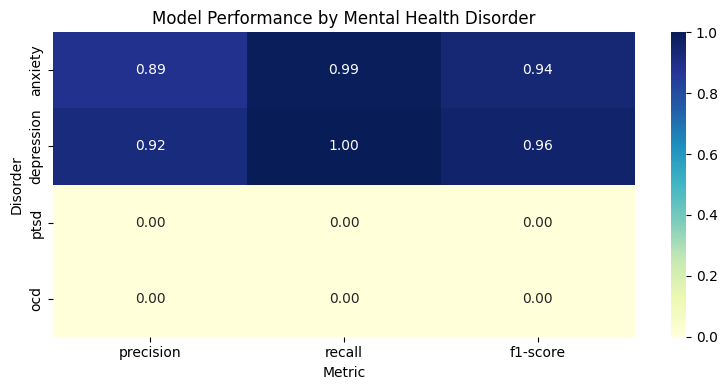

SHAP output type: <class 'numpy.ndarray'>
SHAP output shape: (421, 13, 2)


/tmp/ipython-input-2-1119620788.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mean_Abs_SHAP', y='Feature', data=shap_df, palette='viridis')
/tmp/ipython-input-2-1119620788.py:119: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


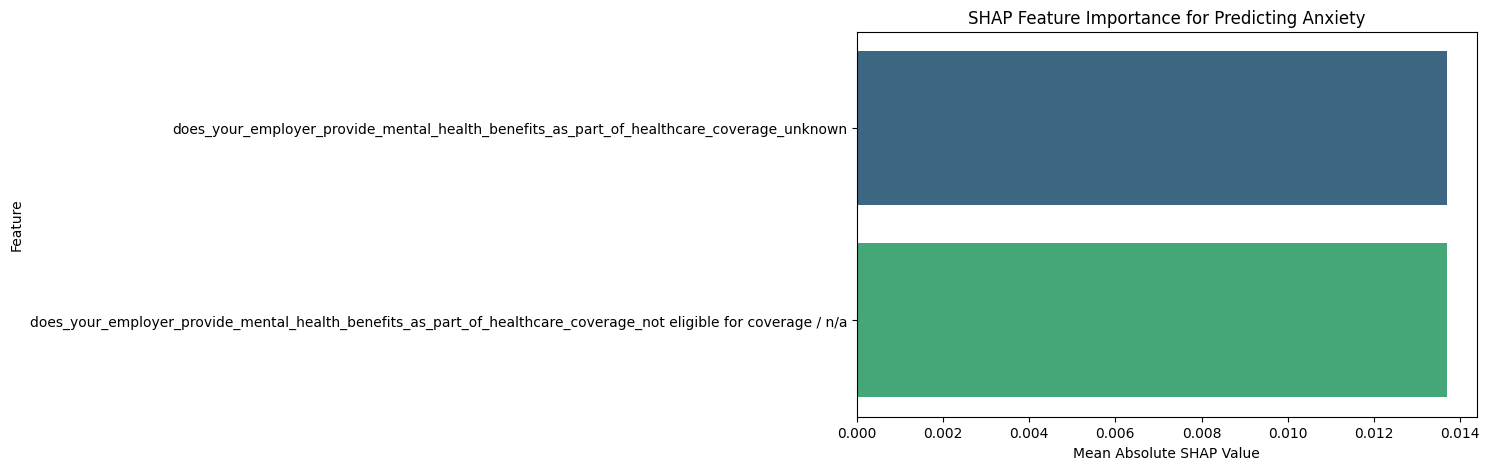

In [ ]:
# --- RQ3: Which specific mental health disorders can be predicted using workplace-related factors, and what are the most influential predictors for each? ---


# ----------------------------
# 1. Import Libraries
# ----------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# ----------------------------
# 2. Load Data
# ----------------------------
df = pd.read_csv('Final_Cleaned_Mental_Health_Data.csv')

# ----------------------------
# 3. Construct Binary Labels
# ----------------------------
df['combined_conditions'] = (
    df['if_so_what_condition_s_were_you_diagnosed_with'].fillna('') + ', ' +
    df['if_yes_what_condition_s_have_you_been_diagnosed_with'].fillna('')
).str.lower().str.split(',\s*')

conditions = ['anxiety', 'depression', 'ptsd', 'ocd']

for condition in conditions:
    df[condition] = df['combined_conditions'].apply(
        lambda x: int(any(condition in str(item) for item in x))
    )

# ----------------------------
# 4. Select Input Features
# ----------------------------
input_features = [
    'does_your_employer_provide_mental_health_benefits_as_part_of_healthcare_coverage',
    'if_a_mental_health_issue_prompted_you_to_request_a_medical_leave_from_work_asking_for_that_leave_would_be',
    'have_you_heard_of_or_observed_negative_consequences_for_co_workers_who_have_been_open_about_mental_health_issues_in_your_workplace',
    'does_your_employer_offer_resources_to_learn_more_about_mental_health_concerns_and_options_for_seeking_help',
    'do_you_believe_your_productivity_is_ever_affected_by_a_mental_health_issue'
]

df_model = df[input_features + conditions].dropna()
X = pd.get_dummies(df_model[input_features], drop_first=True)
Y = df_model[conditions]

# ----------------------------
# 5. Train/Test Split
# ----------------------------
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# ----------------------------
# 6. Train Random Forest Multi-label Classifier
# ----------------------------
model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

# ----------------------------
# 7. Classification Report & Heatmap
# ----------------------------
report = classification_report(Y_test, Y_pred, target_names=conditions, output_dict=True)
metrics_df = pd.DataFrame(report).T.loc[conditions, ['precision', 'recall', 'f1-score']]

plt.figure(figsize=(8, 4))
sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Model Performance by Mental Health Disorder")
plt.ylabel("Disorder")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

# ----------------------------
# 8. SHAP for Feature Importance
# ----------------------------

anxiety_model = model.estimators_[0]

explainer = shap.TreeExplainer(anxiety_model)

shap_values_list = explainer.shap_values(X_test)

print("SHAP output type:", type(shap_values_list))
print("SHAP output shape:", np.array(shap_values_list).shape)

if isinstance(shap_values_list, list) and len(shap_values_list) == 2:
    shap_values_anxiety = shap_values_list[1]
else:
    shap_values_array = np.array(shap_values_list)
    if shap_values_array.ndim == 3:
        shap_values_anxiety = shap_values_array[:, 1, :]
    else:
        shap_values_anxiety = shap_values_array

mean_abs_shap = np.abs(shap_values_anxiety).mean(axis=0)


feature_names = X_test.columns.tolist()
if len(mean_abs_shap) != len(feature_names):
    feature_names = feature_names[:len(mean_abs_shap)]

shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_Abs_SHAP': mean_abs_shap
}).sort_values(by='Mean_Abs_SHAP', ascending=True)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Mean_Abs_SHAP', y='Feature', data=shap_df, palette='viridis')
plt.title("SHAP Feature Importance for Predicting Anxiety")
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

/tmp/ipython-input-5-2849716989.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mean_Abs_SHAP', y='Feature', data=grouped_df, palette='viridis')


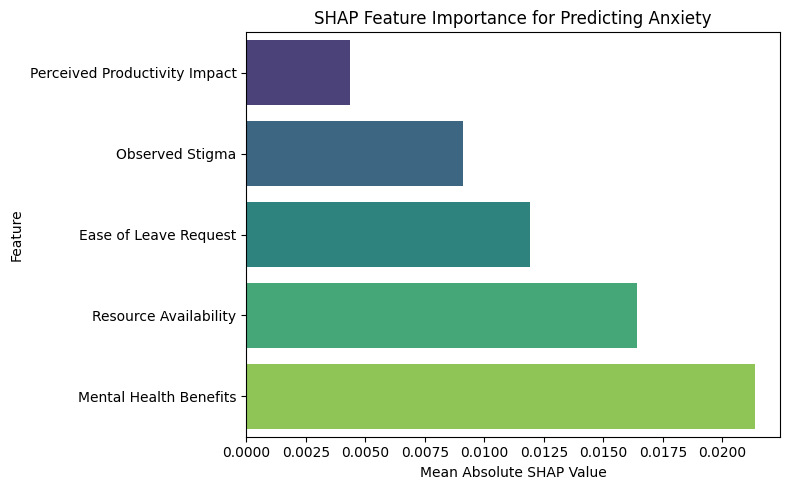

In [ ]:
# ----------------------------
# 8. SHAP for Feature Importance (Grouped + Renamed)
# ----------------------------

import re
from collections import defaultdict

# 1. Get the anxiety model from MultiOutputClassifier
anxiety_model = model.estimators_[0]
explainer = shap.TreeExplainer(anxiety_model)
shap_values = explainer.shap_values(X_test)

# 2. Get SHAP values for the positive class (Anxiety = 1)
if isinstance(shap_values, list):
    shap_values_anxiety = shap_values[1]  # For binary classification
else:
    shap_values_anxiety = shap_values

# 3. Group one-hot encoded features back to their original base feature
group_map = defaultdict(list)
for i, col in enumerate(X_test.columns):
    base_feature = re.sub(r'(_[^_]+)?$', '', col)  # Removes suffix like "_yes", "_no"
    group_map[base_feature].append(i)

# 4. Compute mean absolute SHAP value for each grouped feature
grouped_shap_scores = []
for base_feature, indices in group_map.items():
    mean_val = np.abs(shap_values_anxiety[:, indices]).mean()
    grouped_shap_scores.append((base_feature, mean_val))

# 5. Create DataFrame for SHAP summary
grouped_df = pd.DataFrame(grouped_shap_scores, columns=["Feature", "Mean_Abs_SHAP"])
grouped_df = grouped_df.sort_values(by="Mean_Abs_SHAP", ascending=True)

# 6. Rename long feature names into cleaner, more readable labels
rename_map = {
    'does_your_employer_provide_mental_health_benefits_as_part_of_healthcare_coverage': 'Mental Health Benefits',
    'if_a_mental_health_issue_prompted_you_to_request_a_medical_leave_from_work_asking_for_that_leave_would_be': 'Ease of Leave Request',
    'have_you_heard_of_or_observed_negative_consequences_for_co_workers_who_have_been_open_about_mental_health_issues_in_your_workplace': 'Observed Stigma',
    'does_your_employer_offer_resources_to_learn_more_about_mental_health_concerns_and_options_for_seeking_help': 'Resource Availability',
    'do_you_believe_your_productivity_is_ever_affected_by_a_mental_health_issue': 'Perceived Productivity Impact'
}
grouped_df['Feature'] = grouped_df['Feature'].replace(rename_map)

# 7. Plot the grouped and renamed SHAP values
plt.figure(figsize=(8, 5))
sns.barplot(x='Mean_Abs_SHAP', y='Feature', data=grouped_df, palette='viridis')
plt.title("SHAP Feature Importance for Predicting Anxiety")
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
